In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
!pip install mailbox

  Preparing metadata (setup.py) ... done
  Created wheel for mailbox: filename=mailbox-0.4-py3-none-any.whl size=4683 sha256=6e51d4cc10adb3acbe8a3de36dafafbaa9da60e8e7cb024e1b58d8b1e75fc65d
  Stored in directory: /root/.cache/pip/wheels/06/cd/9a/64b75da2511d797260d3b3cb8cfbf66e700119cc045a9be2c9
Successfully built mailbox


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import mailbox
mboxfile = "gdrive/My Drive/Colab Notebooks/gmail.mbox"

mbox = mailbox.mbox(mboxfile)
mbox

In [6]:
for message in mbox:
    for key in message.keys():
        print(key)
    break


In [7]:
import csv

with open('mailbox.csv', 'w') as outputfile:
  writer = csv.writer(outputfile)
  writer.writerow(['subject','from','date','to','label','thread'])

  for message in mbox:
    writer.writerow([message['subject'], message['from'],  message['date'], message['to'],  message['X-Gmail-Labels'], message['X-GM-THRID']])

In [8]:
dfs = pd.read_csv('mailbox.csv', names=['subject', 'from', 'date', 'to', 'label', 'thread'])

In [9]:
dfs.dtypes

,0
subject,object
from,object
date,object
to,object
label,object
thread,object


In [10]:
dfs['date'] = dfs['date'].apply(lambda x: pd.to_datetime(x, errors='coerce', utc=True))

In [11]:
dfs = dfs[dfs['date'].notna()]

In [12]:
dfs.to_csv('gmail.csv')

In [13]:
dfs.info()


<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   subject  0 non-null      object        
 1   from     0 non-null      object        
 2   date     0 non-null      datetime64[ns]
 3   to       0 non-null      object        
 4   label    0 non-null      object        
 5   thread   0 non-null      object        
dtypes: datetime64[ns](1), object(5)
memory usage: 0.0+ bytes


In [14]:
dfs.head(10)

,subject,from,date,to,label,thread


In [15]:
dfs.columns

Index(['subject', 'from', 'date', 'to', 'label', 'thread'], dtype='object')

In [16]:
import re

def extract_email_ID(string):
  email = re.findall(r'<(.+?)>', string)
  if not email:
    email = list(filter(lambda y: '@' in y, string.split()))
  return email[0] if email else np.nan

In [17]:
dfs['from'] = dfs['from'].apply(lambda x: extract_email_ID(x))

In [18]:
myemail = 'itsmeskm99@gmail.com'
dfs['label'] = dfs['from'].apply(lambda x: 'sent' if x==myemail else 'inbox')

In [19]:
dfs.drop(columns='to', inplace=True)

In [20]:
dfs.head(10)

,subject,from,date,label,thread


In [21]:
import datetime
import pytz

def refactor_timezone(x):
  est = pytz.timezone('US/Eastern')
  return x.astimezone(est)

In [22]:
dfs['date'] = dfs['date'].apply(lambda x: refactor_timezone(x))

In [23]:
dfs['dayofweek'] = dfs['date'].apply(lambda x: x.weekday_name)
dfs['dayofweek'] = pd.Categorical(dfs['dayofweek'], categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
    'Saturday', 'Sunday'], ordered=True)

In [24]:
dfs['timeofday'] = dfs['date'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)

In [25]:
dfs['hour'] = dfs['date'].apply(lambda x: x.hour)

In [26]:
dfs['year_int'] = dfs['date'].apply(lambda x: x.year)

In [27]:
dfs['year'] = dfs['date'].apply(lambda x: x.year + x.dayofyear/365.25)

In [28]:
dfs.index = dfs['date']
del dfs['date']

In [31]:
print(type(dfs.index))
print(dfs.index[:5])


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)


In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [33]:
def plot_todo_vs_year(df, ax, color='C0', s=0.5, title=''):
  ind = np.zeros(len(df), dtype='bool')
  est = pytz.timezone('US/Eastern')

  df[~ind].plot.scatter('year', 'timeofday', s=s, alpha=0.6, ax=ax, color=color)
  ax.set_ylim(0, 24)
  ax.yaxis.set_major_locator(MaxNLocator(8))
  ax.set_yticklabels([datetime.datetime.strptime(str(int(np.mod(ts, 24))), "%H").strftime("%I %p") for ts in ax.get_yticks()]);

  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_title(title)
  ax.grid(ls=':', color='k')

  return ax

In [34]:
sent = dfs[dfs['label']=='sent']
received = dfs[dfs['label']=='inbox']

/tmp/ipython-input-2157647245.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([datetime.datetime.strptime(str(int(np.mod(ts, 24))), "%H").strftime("%I %p") for ts in ax.get_yticks()]);
/tmp/ipython-input-2157647245.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([datetime.datetime.strptime(str(int(np.mod(ts, 24))), "%H").strftime("%I %p") for ts in ax.get_yticks()]);


<Axes: title={'center': 'Received'}>

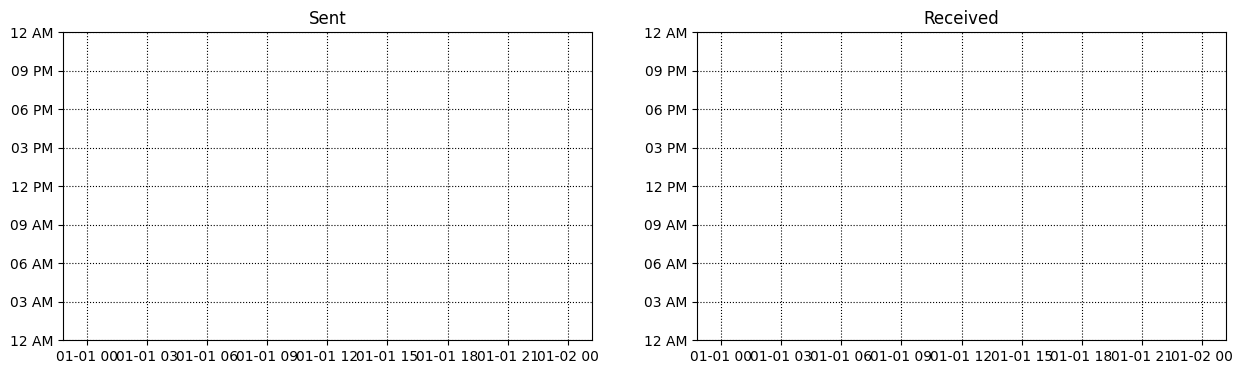

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

plot_todo_vs_year(sent, ax[0], title='Sent')
plot_todo_vs_year(received, ax[1], title='Received')

In [36]:
def plot_number_perday_per_year(df, ax, label=None, dt=0.3, **plot_kwargs):
    year = df[df['year'].notna()]['year'].values
    T = year.max() - year.min()
    bins = int(T / dt)
    weights = 1 / (np.ones_like(year) * dt * 365.25)
    ax.hist(year, bins=bins, weights=weights, label=label, **plot_kwargs);
    ax.grid(ls=':', color='k')

In [37]:
from scipy import ndimage

def plot_number_perdhour_per_year(df, ax, label=None, dt=1, smooth=False,
                      weight_fun=None, **plot_kwargs):

    tod = df[df['timeofday'].notna()]['timeofday'].values
    year = df[df['year'].notna()]['year'].values
    Ty = year.max() - year.min()
    T = tod.max() - tod.min()
    bins = int(T / dt)
    if weight_fun is None:
        weights = 1 / (np.ones_like(tod) * Ty * 365.25 / dt)
    else:
        weights = weight_fun(df)
    if smooth:
        hst, xedges = np.histogram(tod, bins=bins, weights=weights);
        x = np.delete(xedges, -1) + 0.5*(xedges[1] - xedges[0])
        hst = ndimage.gaussian_filter(hst, sigma=0.75)
        f = interp1d(x, hst, kind='cubic')
        x = np.linspace(x.min(), x.max(), 10000)
        hst = f(x)
        ax.plot(x, hst, label=label, **plot_kwargs)
    else:
        ax.hist(tod, bins=bins, weights=weights, label=label, **plot_kwargs);


    ax.grid(ls=':', color='k')
    orientation = plot_kwargs.get('orientation')
    if orientation is None or orientation == 'vertical':
        ax.set_xlim(0, 24)
        ax.xaxis.set_major_locator(MaxNLocator(8))
        ax.set_xticklabels([datetime.datetime.strptime(str(int(np.mod(ts, 24))), "%H").strftime("%I %p")
                            for ts in ax.get_xticks()]);
    elif orientation == 'horizontal':
        ax.set_ylim(0, 24)
        ax.yaxis.set_major_locator(MaxNLocator(8))
        ax.set_yticklabels([datetime.datetime.strptime(str(int(np.mod(ts, 24))), "%H").strftime("%I %p")
                            for ts in ax.get_yticks()]);



In [38]:
class TriplePlot:
  def __init__(self):
    gs = gridspec.GridSpec(6, 6)
    self.ax1 = plt.subplot(gs[2:6, :4])
    self.ax2 = plt.subplot(gs[2:6, 4:6], sharey=self.ax1)
    plt.setp(self.ax2.get_yticklabels(), visible=False);
    self.ax3 = plt.subplot(gs[:2, :4])
    plt.setp(self.ax3.get_xticklabels(), visible=False);

  def plot(self, df, color='darkblue', alpha=0.8, markersize=0.5, yr_bin=0.1, hr_bin=0.5):
    plot_todo_vs_year(df, self.ax1, color=color, s=markersize)
    plot_number_perdhour_per_year(df, self.ax2, dt=hr_bin, color=color, alpha=alpha, orientation='horizontal')
    self.ax2.set_xlabel('Average emails per hour')
    plot_number_perday_per_year(df, self.ax3, dt=yr_bin, color=color, alpha=alpha)
    self.ax3.set_ylabel('Average emails per day')

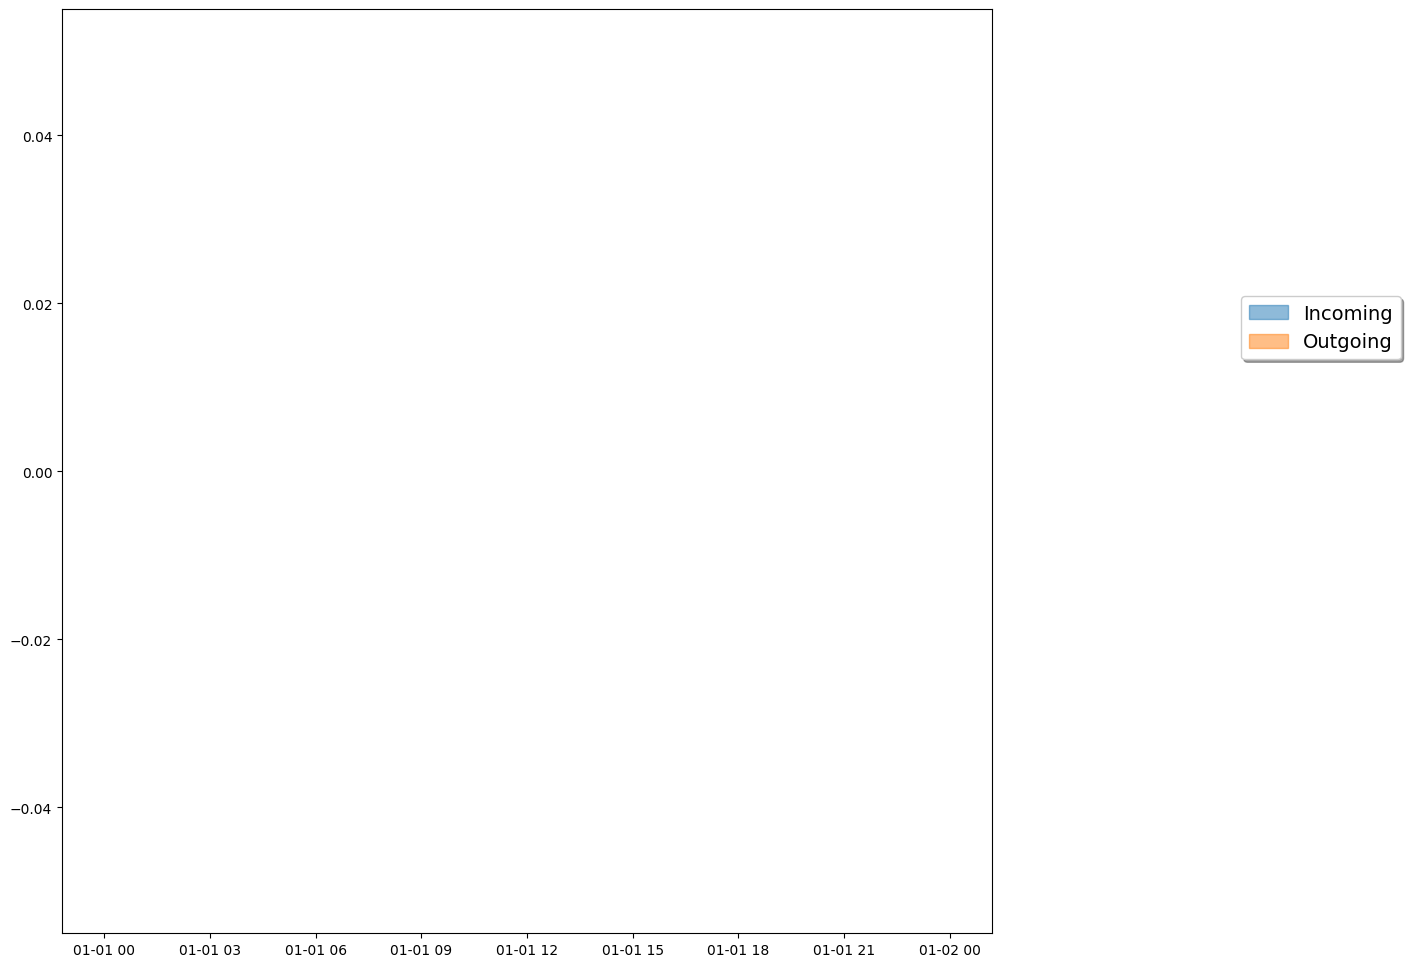

In [40]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Simple TriplePlot replacement
class TriplePlot:
    def __init__(self):
        self.fig = plt.gcf()
        self.gs = gridspec.GridSpec(3, 1)
        self.ax = self.fig.add_subplot(self.gs[:, 0])

    def plot(self, data, **kwargs):
        self.ax.plot(data, **kwargs)

# create figure
plt.figure(figsize=(12, 12))

tpl = TriplePlot()

tpl.plot(received, color='C0', alpha=0.5)
tpl.plot(sent, color='C1', alpha=0.5)

# legend patches
p1 = mpatches.Patch(color='C0', label='Incoming', alpha=0.5)
p2 = mpatches.Patch(color='C1', label='Outgoing', alpha=0.5)

plt.legend(handles=[p1, p2],
           bbox_to_anchor=(1.45, 0.7),
           fontsize=14,
           shadow=True)

plt.show()


<Axes: xlabel='dayofweek'>

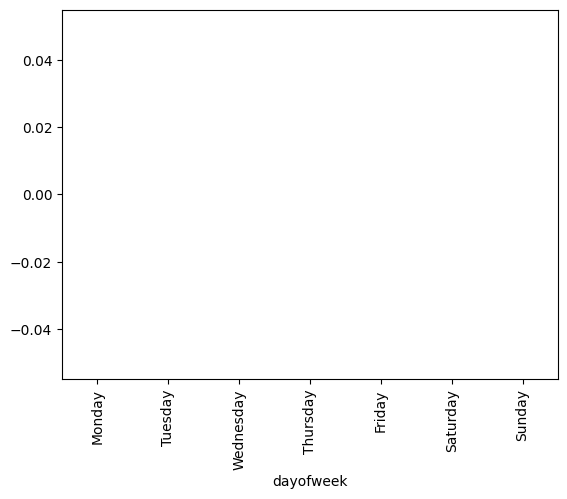

In [41]:
counts = dfs.dayofweek.value_counts(sort=False)
counts.plot(kind='bar')

In [42]:
addrs = received['from'].value_counts()

addrs[0:4]

,count
from,


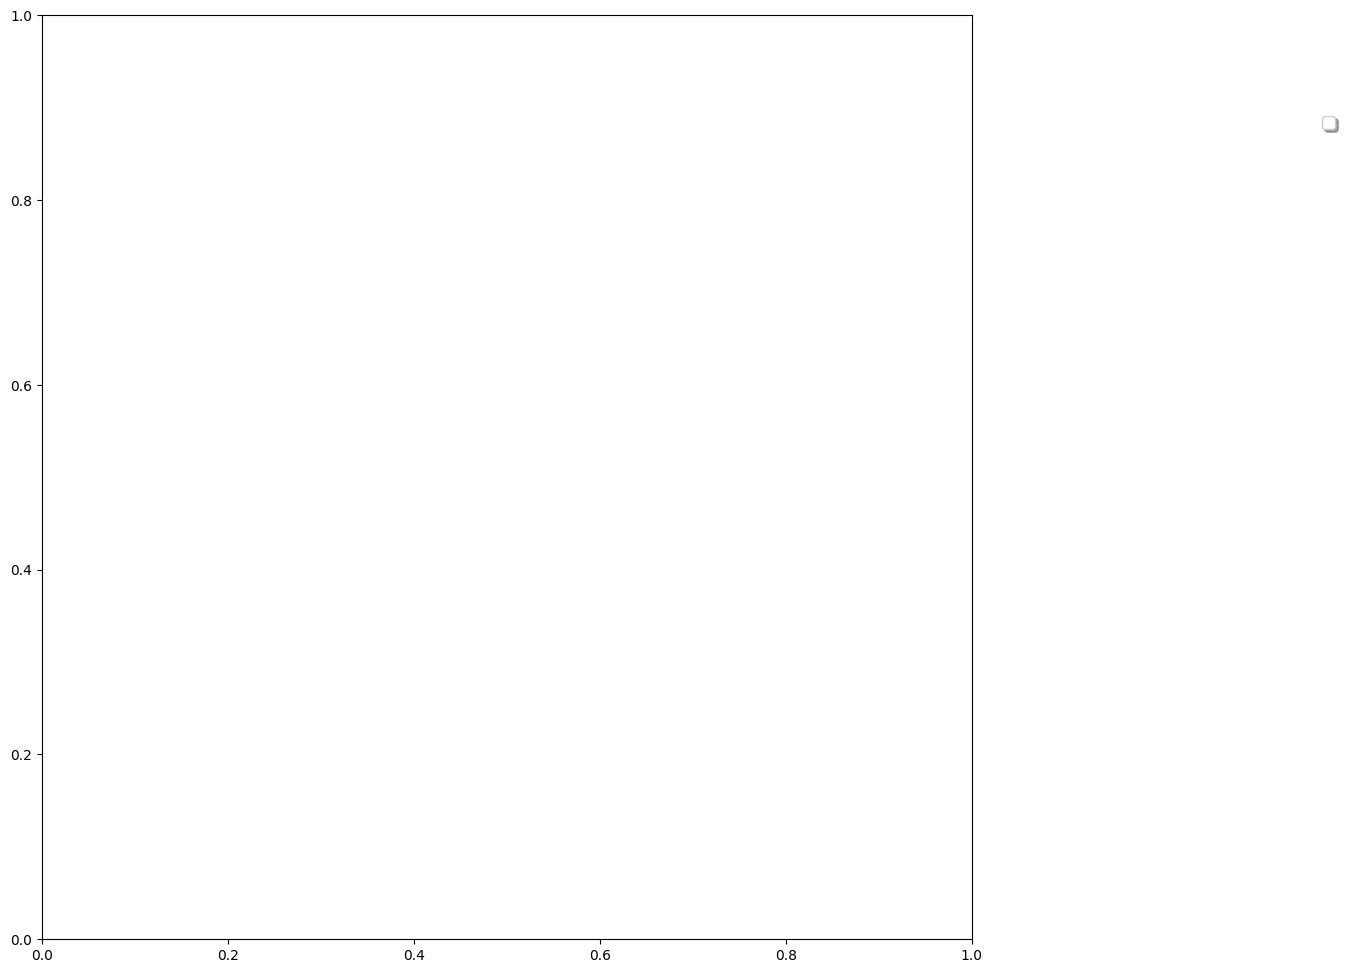

In [46]:
plt.figure(figsize=(12, 12))

tpl = TriplePlot()

labels = []
colors = ['C{}'.format(ii) for ii in range(9)]

# take first 4 addresses safely
for ct, addr in enumerate(addrs.index[:4]):
    data = dfs[dfs['from'] == addr]

    if data.empty:
        continue   # skip if no data

    tpl.plot(data, color=colors[ct], alpha=0.3)

    labels.append(
        mpatches.Patch(
            color=colors[ct],
            label=str(addr),
            alpha=0.5
        )
    )

plt.legend(handles=labels, bbox_to_anchor=(1.4, 0.9),
           fontsize=12, shadow=True)
plt.show()


/tmp/ipython-input-2993220249.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sdw = sent.groupby('dayofweek').size() / len(sent)
/tmp/ipython-input-2993220249.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rdw = received.groupby('dayofweek').size() / len(received)


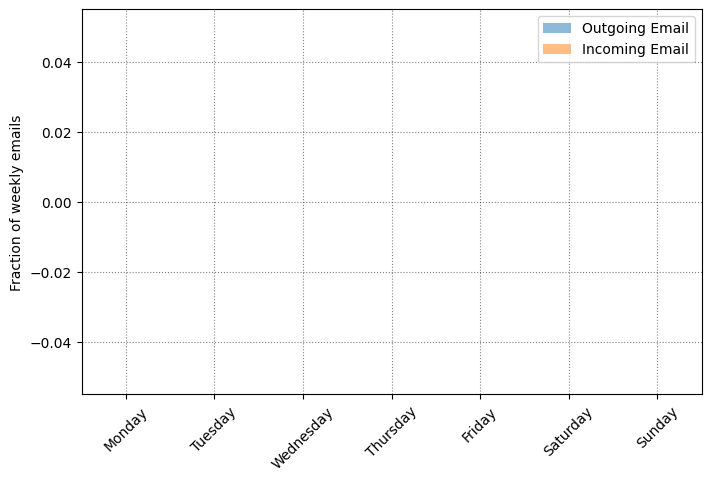

In [47]:
sdw = sent.groupby('dayofweek').size() / len(sent)
rdw = received.groupby('dayofweek').size() / len(received)

df_tmp = pd.DataFrame(data={'Outgoing Email': sdw, 'Incoming Email':rdw})
df_tmp.plot(kind='bar', rot=45, figsize=(8,5), alpha=0.5)
plt.xlabel('');
plt.ylabel('Fraction of weekly emails');
plt.grid(ls=':', color='k', alpha=0.5)

/tmp/ipython-input-3037519974.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


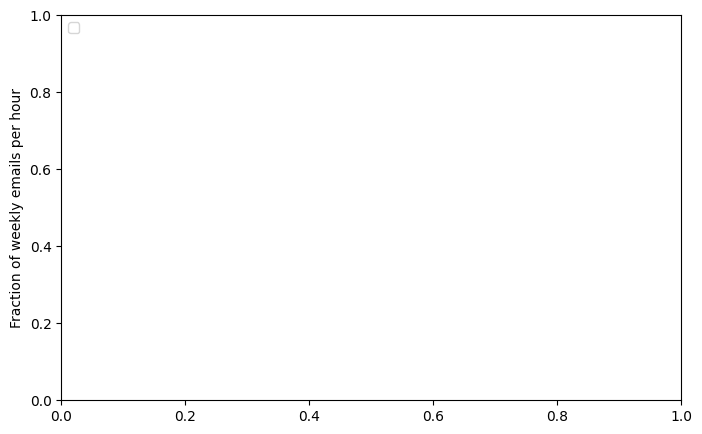

In [49]:
import scipy.ndimage
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

# ensure dayofweek column exists
if 'dayofweek' not in dfs.columns:
    dfs['dayofweek'] = dfs.index.dayofweek

# get unique days safely
days = sorted(dfs['dayofweek'].dropna().unique())

for ct, dow in enumerate(days):
    # ---------- RECEIVED ----------
    df_r = received[received['dayofweek'] == dow]

    if not df_r.empty and len(received) > 0:
        weights = np.ones(len(df_r)) / len(received)
        wfun = lambda x, w=weights: w

        plot_number_perdhour_per_year(
            df_r, ax,
            dt=1, smooth=True,
            color=f'C{ct}',
            alpha=0.8, lw=3,
            label=f'{dow} (recv)',
            weight_fun=wfun
        )

    # ---------- SENT ----------
    df_s = sent[sent['dayofweek'] == dow]

    if not df_s.empty and len(sent) > 0:
        weights = np.ones(len(df_s)) / len(sent)
        wfun = lambda x, w=weights: w

        plot_number_perdhour_per_year(
            df_s, ax,
            dt=1, smooth=True,
            color=f'C{ct}',
            alpha=0.8, lw=2,
            ls='--',
            label=f'{dow} (sent)',
            weight_fun=wfun
        )

ax.set_ylabel('Fraction of weekly emails per hour')
plt.legend(loc='upper left')
plt.show()


In [50]:
from wordcloud import WordCloud

df_no_arxiv = dfs[dfs['from'] != 'no-reply@arXiv.org']
text = ' '.join(map(str, sent['subject'].values))

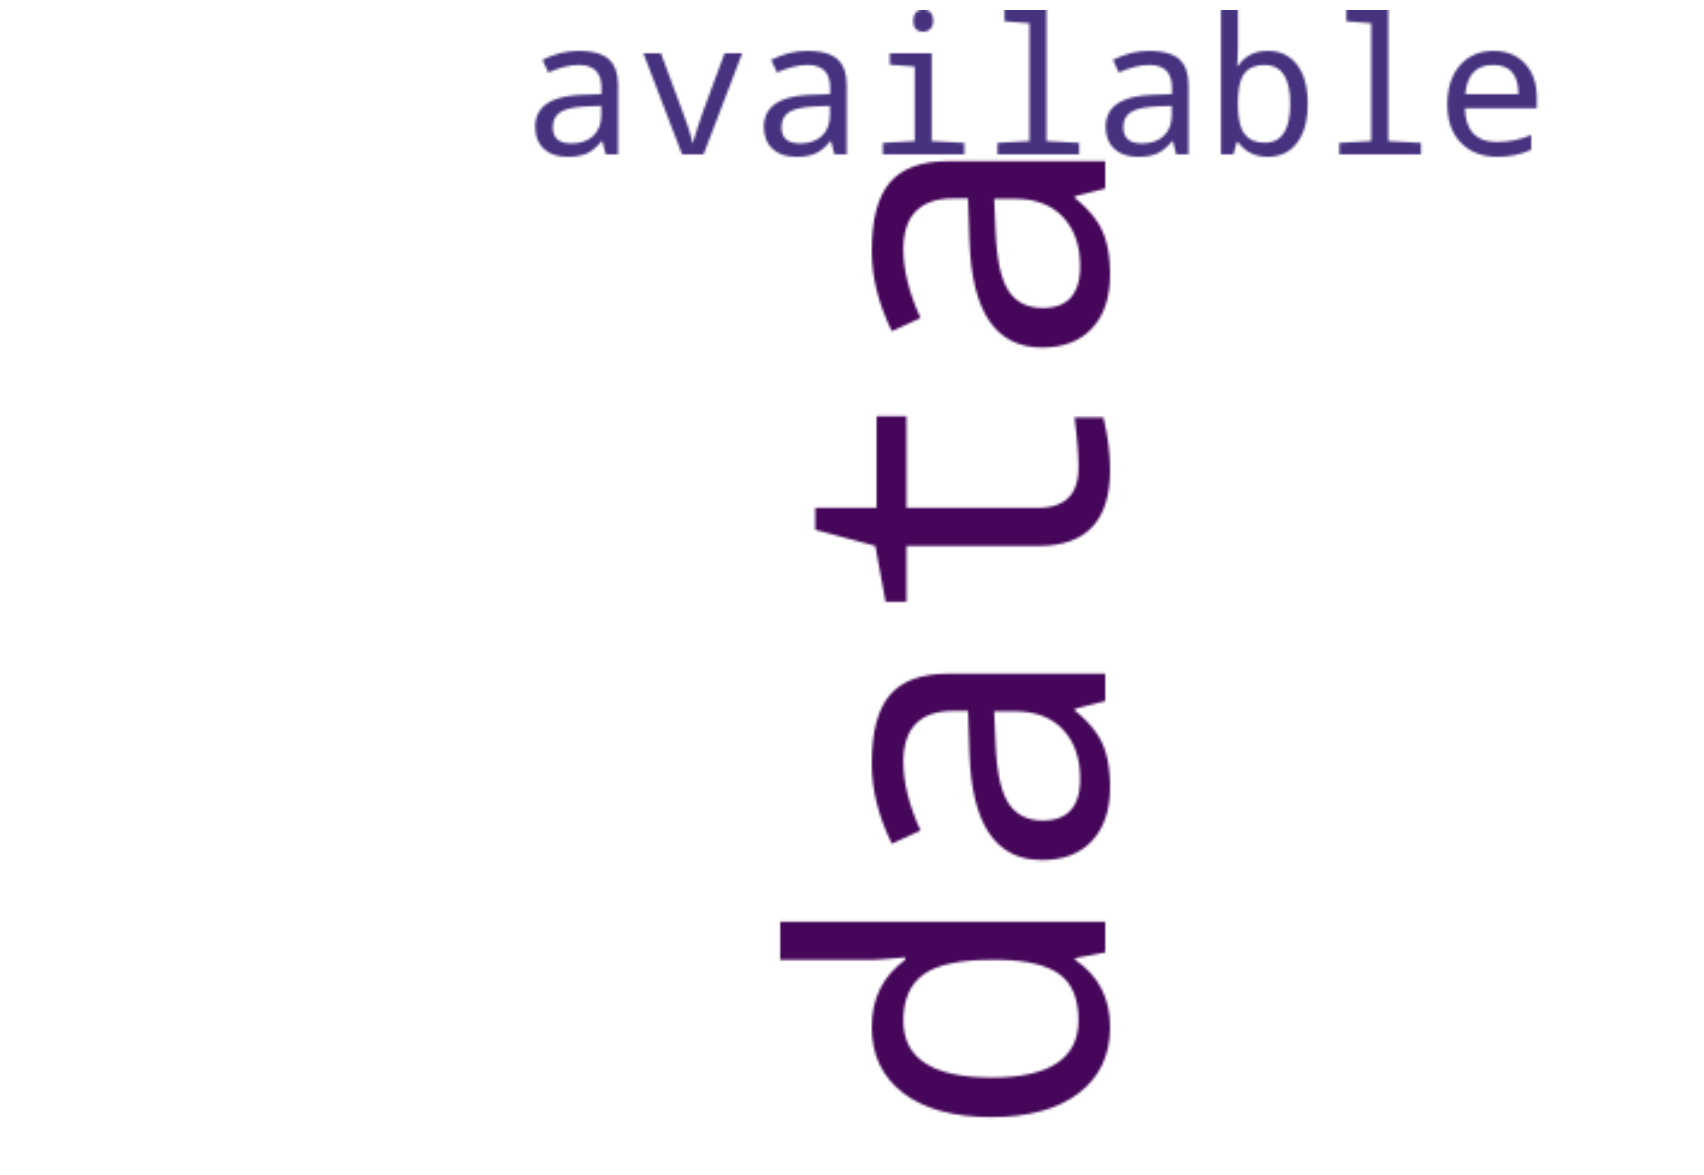

In [53]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

stopwords = ['re', 'fwd', '3a_']

# ensure text is usable
if not isinstance(text, str):
    text = " ".join(map(str, text))

if not text.strip():
    text = "no data available"

wrd = WordCloud(
    width=700,
    height=480,
    margin=0,
    collocations=False,
    background_color='white'
)

for sw in stopwords:
    wrd.stopwords.add(sw.lower())

wordcloud = wrd.generate(text.lower())

plt.figure(figsize=(25, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
